<div class="alert alert-block alert-warning"> <b>Disclaimer</b> 
    This notebook is just an early proof of concept, and not proper research. 
</div>

# Regime Aware Factor Investing 
A couple of stylized facts about the performance of stocks:

1. It is highly tied to the business cycle, which can be modeled through regime switching models
2. It is a low-rank space; a bunch of factors (probably between 3 and 6) can to explain most of the cross-sectional variance

I would like to explore in future work how can we combine the regime-dependent behavior of stocks and the low-rank nature of the space, to construct regime-aware stock portfolios that are able to provide better risk adjusted returns.

If equity factors' performance behavior is indeed regime-dependent, we could fit a Markov-switching model on their time series, and that way get better estimates for their premia/risk, and consequently better inputs for stock portfolio optimization.  

<div class="alert alert-block alert-info"> 
    The objective of this notebook is to explore the notion of regime-dependent behavior across commonly accepted equity factors, such as market, size, and value.
</div>

In [1]:
import pandas as pd
import numpy as np
import pandas_datareader.data as web
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as mtick
import statsmodels.api as sm
from matplotlib.lines import Line2D

## Data
For this exercise we will use the **monthly returns** published for the market risk (Mkt-RF), size (SMB), and value (HML) factors, available on the Ken French's data library. This neither a comprehensive nor definitive list of factors, but rather a fair starting point for this proof-of-concept notebook.

We are additionally obtaining the business cycle peak-to-trough indicator from NBER.

In [2]:
# Fama-French factors
rt_ff_raw = web.DataReader(
    name='F-F_Research_Data_Factors', 
    data_source='famafrench',
    start='12/31/1926',
    end='12/31/2022'
)[0].div(100)
rt_ff_raw.index = pd.DatetimeIndex(rt_ff_raw.index.to_timestamp())
rt_ff = rt_ff_raw.resample('M').last()

# Business cycle (1: Peak-to-trough)
usrec_flag = web.DataReader(
    name='USREC', 
    data_source='fred',
    start='11/30/1926',
    end='12/31/2022'
).squeeze()
usrec_flag = usrec_flag.resample('M').ffill().reindex(rt_ff.index)

## Factors Across the Business Cycle
This section is model-free, as we will be using the NBER recession indicator to analyze the factor performance across the recession and expansion states.

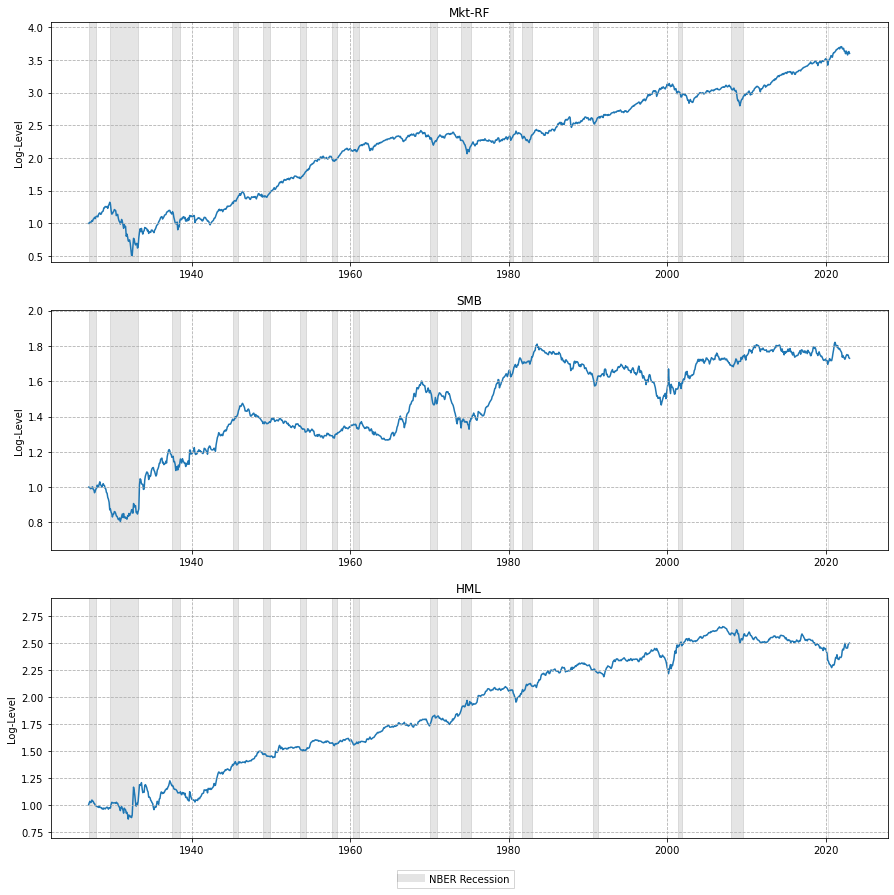

In [3]:
px_ff = rt_ff.add(1).cumprod()
data = px_ff.div(px_ff.iloc[0]).mul(10).apply(np.log10)
data.drop('RF', axis=1, inplace=True)

fig, axs = plt.subplots(len(rt_ff.columns) - 1, 1, figsize=(15, 15))

for i, factor in enumerate(data):
    axs[i].plot(data[factor], zorder=1)
    axs[i].set_title(factor)
    axs[i].grid(ls='--', zorder=-20)
    axs[i].set_ylim(data[factor].min() * .8, data[factor].max() * 1.1)
    axs[i].fill_between(usrec_flag.index, 0, 1000, where=usrec_flag.values, color="k", alpha=0.1)
    axs[i].set_ylabel('Log-Level')

custom_lines = [Line2D([0], [0], color='k', alpha=.1, lw=8),]
fig.legend(custom_lines, ['NBER Recession'], loc='upper center', bbox_to_anchor=(0.5, 0.1), fancybox=False, shadow=False, ncol=3)
plt.show()

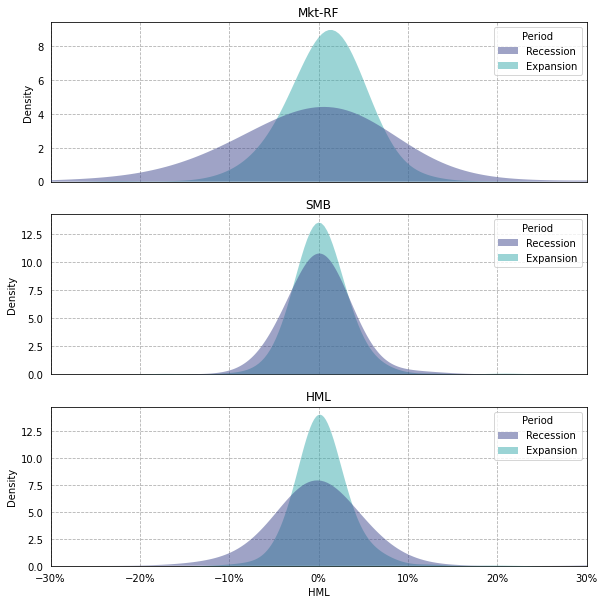

In [4]:
data = rt_ff.drop('RF', axis=1)
data['Period'] = usrec_flag
data['Period'] = data['Period'].replace({1: 'Recession', 0: 'Expansion'})

fig, axs = plt.subplots(nrows=len(rt_ff.columns) - 1, ncols=1, figsize=(8.5, 8.5), sharex=True, sharey=False)
for i, factor in enumerate(rt_ff.drop('RF', axis=1)):
    sns.kdeplot(
        data=data, 
        x=factor, 
        hue='Period',
        fill=True, 
        common_norm=False, 
        palette="mako",
        alpha=.5, 
        linewidth=0,
        ax=axs[i],
        zorder=50,
        bw_adjust=2
    )
    axs[i].tick_params(left=False, bottom=False)
    axs[i].set_xlim(-.3, .3)
    axs[i].grid(ls='--', zorder=-25)
    axs[i].xaxis.set_major_formatter(mtick.PercentFormatter(xmax=1, decimals=0))
    axs[i].set_title(factor)
plt.tight_layout()
plt.show()

As expected, the regime-dependance seem to be more apparent in the market factor (Mkt-RF), than in size (SMB) and value (HML). During the expansion state of the NBER business cycle indicator, Mkt-RF presents as less volatile with positive expected value distribution, in contrast to the recession state, where the expected value turns negative, and the volatility spikes. This result is expected, as the business cycle is closely related to the market risk premium. Even though the contrast is not as stark in the case of the other two factors, we can still appreciate an increase of volatility during the contractionary state, which might be an early indication of other idiosyncratic regime behavior not strongly related to the business cycle, in these factors. 

Text(0.5, 1.0, 'Annualized Volatility')

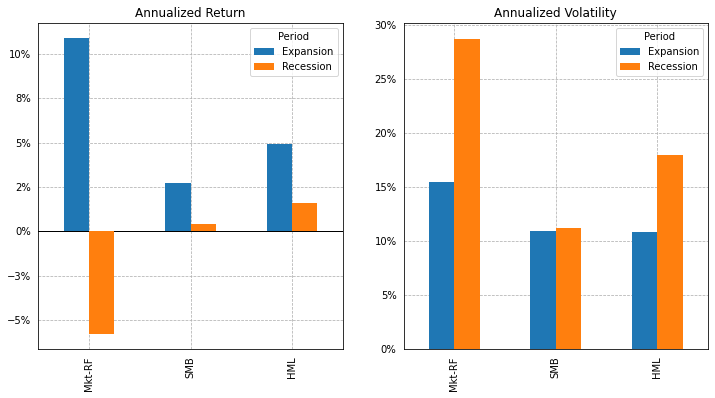

In [5]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 6), sharex=True, sharey=False)
x_labels = list(data.drop('Period', axis=1).columns)

data.groupby('Period').mean().mul(12).T.plot.bar(ax=axs[0], zorder=10)
data.groupby('Period').std().mul(np.sqrt(12)).T.plot.bar(ax=axs[1], zorder=10)
for i in range(2):
    axs[i].grid(ls='--', lw=.75, zorder=-15)
    axs[i].axhline(0, c='k', lw=1)
    axs[i].tick_params(left=False, bottom=False)
    axs[i].yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1, decimals=0))
    
axs[0].set_title('Annualized Return')
axs[1].set_title('Annualized Volatility')

There is something else that would be very interesting to investigate, which is the different correlation structures between the factors across different states. In the industry is commonly accepted that during market crisis events, the correlation between securities (and hence factors explaining their performance) spikes, erasing any diversification efforts. It would be interesting to incorporate this dynamic into portfolio construction.

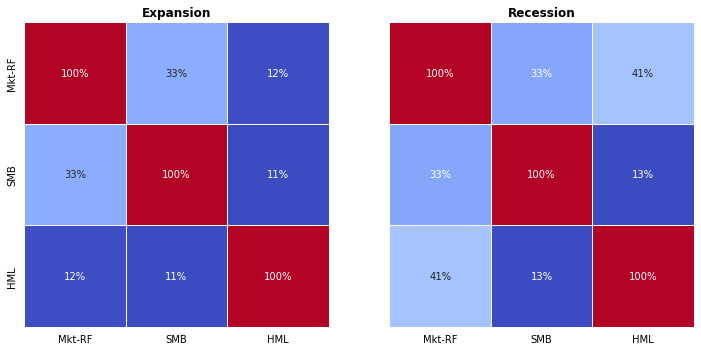

In [6]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 6), sharex=True, sharey=True)

for i, state in enumerate(['Expansion', 'Recession']):
    sns.heatmap(
        data.groupby('Period').corr().xs(state),
        annot=True,
        fmt='.0%',
        ax=axs[i],
        square=True,
        cbar=False,
        linewidth=1,
        cmap='coolwarm'
    )
    axs[i].tick_params(left=False, bottom=False)
    axs[i].set_title(state, weight='bold')
plt.show()

## Markov-Switching Toy Model
Just for illustrative purposes, we can go one step-forward and try to fit a Markov Switching model on one of the factors, such as the value (HML) factor. As mentioned before, this is not meant to be proper research, but just a thought experiment.

In this case, we will fit a **two-state switching AR(1)**, while allowing the model to switch intercept, and variance. 

\begin{align}
y_{t}= a_{S_{t}}+\phi_{1} \left( y_{t-1} - a_{S_{t-1}} \right) + \varepsilon_{t} \\
\varepsilon \sim N(0, \sigma^{2}_{S_{t}})
\end{align}

While this exercise is univariate (again, for the sake of illustration), a working prototype should be multivariate, and include all the factors at the same time.

Optimization terminated successfully.
         Current function value: -2.146907
         Iterations: 28
         Function evaluations: 33
         Gradient evaluations: 33
                         Markov Switching Model Results                         
Dep. Variable:                      HML   No. Observations:                 1152
Model:             MarkovAutoregression   Log Likelihood                2473.237
Date:                  Fri, 17 Mar 2023   AIC                          -4932.474
Time:                          01:53:44   BIC                          -4897.129
Sample:                      12-31-1926   HQIC                         -4919.133
                           - 12-31-2022                                         
Covariance Type:                 approx                                         
                             Regime 0 parameters                              
                 coef    std err          z      P>|z|      [0.025      0.975]
---------------------

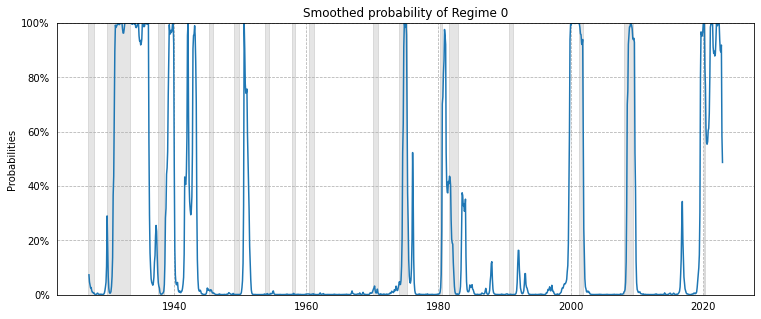

In [7]:
mdl = sm.tsa.MarkovAutoregression(
    endog=rt_ff['HML'],
    k_regimes=2,
    order=1,
    switching_ar=False,
    switching_variance=True,
    switching_trend=True
)

np.random.seed(12345)
res = mdl.fit(search_reps=20, disp=True)

print(res.summary())

fig, ax = plt.subplots(figsize=(12.5, 5))

ax.fill_between(usrec_flag.index, 0, 10, where=usrec_flag.values, color="k", alpha=0.1)
ax.plot(res.smoothed_marginal_probabilities[0])
ax.set_ylim(0, 1)
ax.grid(ls='--', lw=.75, zorder=-15)
ax.tick_params(left=False, bottom=False)
ax.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1, decimals=0))
ax.set_ylabel('Probabilities')
ax.set_title('Smoothed probability of Regime 0')
plt.show()

It seems like, under this specification, the value factor switches between a sticky low-volatility, muted-performance state, into a high-volatility, high-performance state. Interestingly enough, some of these changes seem to align somewhat to the NBER cycle indicator, which confirms our observations in the previous section. 